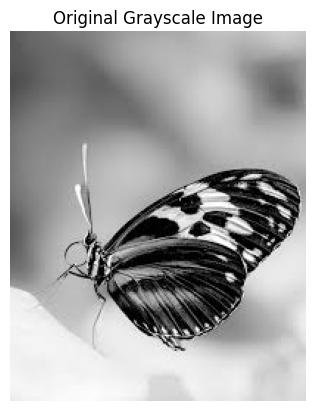

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image and convert to grayscale
image = cv2.imread('images.jpg', cv2.IMREAD_GRAYSCALE)

# Display the image
plt.imshow(image, cmap='gray')
plt.title("Original Grayscale Image")
plt.axis("off")
plt.show()

In [2]:
sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

sobel_y = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
])

In [9]:
height, width = image.shape

In [10]:
# Sobel filter requires 3*3 neighborhood for each pixel so we exclude the boundary pixels
gradient_x = np.zeros((height-2, width-2))
gradient_y = np.zeros((height-2, width-2))
gradient_magnitude = np.zeros((height-2, width-2))

In [11]:
for i in range(1, height-1):
    for j in range(1, width-1):
        region = image[i-1:i+2, j-1:j+2]
        gx = np.sum(region * sobel_x)
        gy = np.sum(region * sobel_y)

        gradient_x[i-1, j-1] = gx
        gradient_y[i-1, j-1] = gy
        gradient_magnitude[i-1, j-1] = np.sqrt(gx**2 + gy**2)

In [12]:
gradient_magnitude = (gradient_magnitude / np.max(gradient_magnitude) * 255).astype(np.uint8)

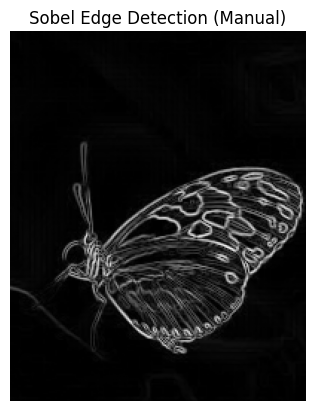

In [13]:
plt.imshow(gradient_magnitude, cmap='gray')
plt.title("Sobel Edge Detection (Manual)")
plt.axis("off")
plt.show()

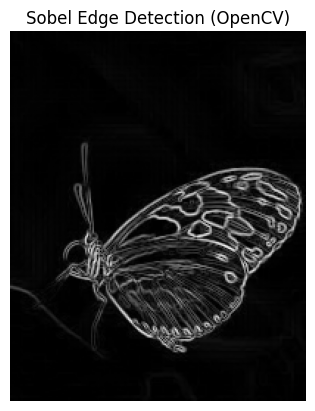

In [15]:
sobel_x_opencv = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y_opencv = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

sobel_magnitude = np.sqrt(sobel_x_opencv**2 + sobel_y_opencv**2)
sobel_magnitude = (sobel_magnitude / np.max(sobel_magnitude) * 255).astype(np.uint8)

plt.imshow(sobel_magnitude, cmap='gray')
plt.title("Sobel Edge Detection (OpenCV)")
plt.axis("off")
plt.show()

In [9]:
# !python setup.py install

In [6]:
# !pip list | grep sobel_cuda

DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/sobel_cuda-0.0.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
sobel_cuda                         0.0.0
sobel_cuda                         0.0.0


In [1]:
!pip install .

Processing /content
  Preparing metadata (setup.py) ... done
  Created wheel for sobel_cuda: filename=sobel_cuda-0.0.0-cp311-cp311-linux_x86_64.whl size=2698169 sha256=adf8fc24e335c9c1b81e689c5d8f5cd00da5719741e0789ae9150ae18854d612
  Stored in directory: /tmp/pip-ephem-wheel-cache-e6eleei2/wheels/01/d1/e4/ca90c6fac4331f6da6de5353843d0b67505c2bbc8768ac296e
Successfully built sobel_cuda


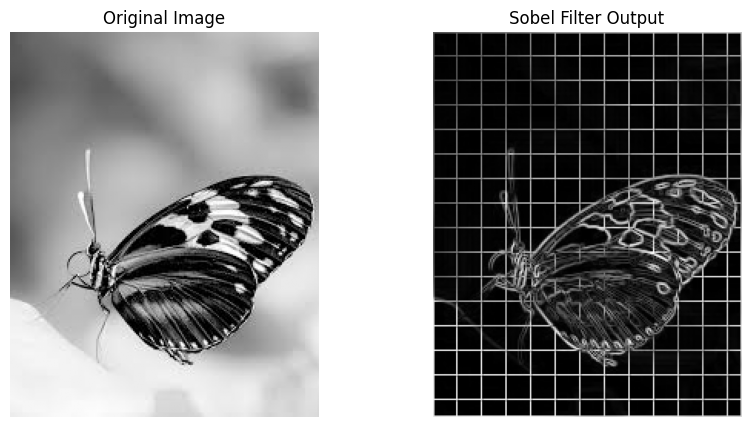

In [2]:
import torch
import sobel_cuda
import cv2
import matplotlib.pyplot as plt

image_path = "images.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

image_tensor = torch.tensor(image, dtype=torch.float32, device="cuda") / 255.0

output = sobel_cuda.forward(image_tensor)

image_np = image_tensor.cpu().numpy()
output_np = output.cpu().numpy()

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(image_np, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(output_np, cmap="gray")
plt.title("Sobel Filter Output")
plt.axis("off")

plt.show()

In [3]:
!pip install torch-tb-profiler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.2 MB/s eta 0:00:00


In [4]:
import cv2
import numpy as np
import torch
import time

# Load grayscale image
image_path = "images.jpg"  # Change this to your image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Convert to float32 for fair comparison
image_np = np.float32(image) / 255.0

# Measure time for OpenCV Sobel filter
start_time = time.time()
sobel_x = cv2.Sobel(image_np, cv2.CV_32F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(image_np, cv2.CV_32F, 0, 1, ksize=3)
sobel_opencv = np.sqrt(sobel_x**2 + sobel_y**2)
opencv_time = time.time() - start_time

print(f"OpenCV Sobel Execution Time: {opencv_time:.6f} seconds")

OpenCV Sobel Execution Time: 0.021259 seconds


In [5]:
import sobel_cuda

image_tensor = torch.tensor(image_np, dtype=torch.float32, device="cuda")

sobel_cuda.forward(image_tensor)
start_time = time.time()
sobel_cuda_output = sobel_cuda.forward(image_tensor)
torch.cuda.synchronize()  # Ensure all operations finish before timing
cuda_time = time.time() - start_time

print(f"CUDA Sobel Execution Time: {cuda_time:.6f} seconds")

CUDA Sobel Execution Time: 0.000403 seconds


In [7]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("CUDA Sobel Filter"):
        sobel_cuda_output = sobel_cuda.forward(image_tensor)

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                      CUDA Sobel Filter         0.00%       0.000us         0.00%       0.000us       0.000us     874.923us      5534.68%     874.923us     874.923us             1  
            SobelFilterKernel(float*, float*, int, int)         0.00%       0.000us         0.00%       0.000us       0.000us      11.296us        71.46%      11.296us      11.296us             1  
         